# Toy Model (Naive Bayes)

In [55]:
import re
import math
from gensim import utils

class Classifier:
    def __init__(self, filename=None):
        # count of feature/category combinations
        self.fc = {}
        # count of documents in each category
        self.cc = {}
        # some samples
        self.train_samples = [
            ['i enjoyed this movie', 'good'],
            ['this book was fun', 'good'],
            ['this cake tasted horrid', 'bad'],
            ['i was happy when this ended', 'bad']]
        
    # Increment the category count for feature
    # e.g. (loved, good) -> 'loved': {'good': 1}
    def inc_count_feat_categ(self, f, cat):
        self.fc.setdefault(f,{})
        self.fc[f].setdefault(cat, 0)
        self.fc[f][cat] += 1
        
    # Return count of feature appearing in category, e.g.
    # (loved, good) will return 1.0
    def feat_count(self, f, cat):
        if f in self.fc and cat in self.fc[f]:
            return float(self.fc[f][cat])
        return 0
    
    # Increment category count 
    # e.g. (good) -> {'good': 1}
    def inc_count_category(self, cat):
        self.cc.setdefault(cat, 0)
        self.cc[cat] += 1
            
    # Return number of items in category
    def cat_count(self, cat):
        if cat in self.cc:
            return float(self.cc[cat])
        return 0
    
    # Total number of items supplied
    def total_count(self):
        return sum(self.cc.values())
    
    # List of all categories
    def list_categories(self):
        return self.cc.keys()
    
    # Start counting number of times word appears in a category
    def train(self, features, cat):      
        # Inc count for every feature in this category
        for f in features:
            self.inc_count_feat_categ(f, cat)
        # Inc count for category
        self.inc_count_category(cat)     

    # Return conditional probability of observing feature, given 
    # a category
    def feat_prob(self, f, cat):
        if self.cat_count(cat) == 0:
            return 0
        # Number of times feature appears in category, 
        # Divided by total number of features in category
        return self.feat_count(f, cat)/self.cat_count(cat)
    
    def weighted_prob(self, f, cat, weight=1.0, ap=0.5):
        # Assumed probability (prior) is 0.5
        # Calculate current probability (observing word, given category)
        basic_prob = self.feat_prob(f, cat)
        
        # Calculate number of times feature has appeared
        # in all categories (e.g. 4 in bad, 2 in good)
        totals = sum([self.feat_count(f,c) for c in self.list_categories()])
        
        # Calculate weighted average
        bp = ((weight*ap)+(totals*basic_prob))/(weight+totals)
        # Return average of prior and basic probability
        return bp
        
    def doc_prob(self, features, cat):
        # Simply multiple all probabilities together
        p = 1
        for f in features:
            p*= self.weighted_prob(f, cat)
        # Probability of document given category
        return p
    
    # We want the probability of category given document
    def prob(self, features, cat):
        # p(Cat|Doc) = p(Doc|Cat) * p(Cat) \ p(Doc)
        # If equal classes then cat_prob will 0.5
        # p(Doc) is same no matter what category so will scale results by same amount
        cat_prob = self.cat_count(cat)/self.total_count()
        doc_prob = self.doc_prob(features, cat)
        return doc_prob*cat_prob

# Yield a review from a large .txt containing the reviews
# Formatted as a dictionary of words
def para_to_dict(para):
    words = utils.to_unicode(para).split()
    return dict([(w,1) for w in words])    

def get_words(fname):
    with utils.smart_open(fname) as f:
        for paragraph in f:
            yield para_to_dict(paragraph)

def get_sentiment(paragraph):
    if not isinstance(paragraph, dict):
        raise Exception("Supply a dictionary of words")
    p_good = classy.prob(paragraph, 'good')
    p_bad = classy.prob(paragraph, 'bad')
    if p_good > p_bad: 
        return 'good'
    else:
        return 'bad'

# Initialise with our feature extraction function (words)
classy = Classifier()

# Train sample
for sample_review, sentiment in classy.train_samples:
    print("Review: ", para_to_dict(sample_review), "Sentiment: ", sentiment)
    classy.train(para_to_dict(sample_review), sentiment)

# Examine model
print("Trained Model:")
for k in classy.fc.keys():
    print(k, classy.fc[k])

# Predict sentiment
print("Some predictions:")
print(get_sentiment(para_to_dict('i enjoyed this book'))) # good
print(get_sentiment(para_to_dict('my trip was horrid'))) # bad
print(get_sentiment(para_to_dict('i am happy'))) # bad

Review:  {'movie': 1, 'enjoyed': 1, 'this': 1, 'i': 1} Sentiment:  good
Review:  {'fun': 1, 'book': 1, 'was': 1, 'this': 1} Sentiment:  good
Review:  {'horrid': 1, 'tasted': 1, 'cake': 1, 'this': 1} Sentiment:  bad
Review:  {'ended': 1, 'i': 1, 'this': 1, 'when': 1, 'happy': 1, 'was': 1} Sentiment:  bad
Trained Model:
ended {'bad': 1}
movie {'good': 1}
happy {'bad': 1}
this {'bad': 2, 'good': 2}
horrid {'bad': 1}
book {'good': 1}
enjoyed {'good': 1}
was {'bad': 1, 'good': 1}
tasted {'bad': 1}
i {'bad': 1, 'good': 1}
fun {'good': 1}
when {'bad': 1}
cake {'bad': 1}
Some predictions:
good
bad
bad


In [56]:
# Apply to movie reviews
classy = Classifier()

# Train
i = 0
for f in ['train_good_reviews.txt',
          'train_bad_reviews.txt']:
    for review in getwords(f):
        i += 1
        classy.train(x, f.split("_")[1])
        if i % 100000 == 0:
            print(i)
            
# Test
tot = 0
correct = 0

for f in ['test_good_reviews.txt',
          'test_bad_reviews.txt']:
    for review in getwords(f):
        tot += 1
        if get_sentiment(review) ==  f.split("_")[1]:
            correct += 1
        if tot % 100000 == 0:
            print(tot)
            
acc = correct/tot
print(acc)  # 0.49989456610705085

100000
200000
300000
400000
500000
600000
700000
800000
900000
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
0.49989456610705085


# 3. TFIDF Approach

## A. Model

In [1]:
from gensim import utils

def file_to_list(fname):
    with utils.smart_open(fname) as f:
        for rev in f:
            yield rev

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Training Data
clean_train_reviews = []
train_labels = []
for f in ['train_good_reviews.txt',
          'train_bad_reviews.txt']:
    for review in file_to_list(f):
        clean_train_reviews.append(utils.to_unicode(review))
        if "good" in f:
            train_labels.append(1)
        elif "bad" in f:
            train_labels.append(0)
        else:
            raise Exception
        
print("Sample review: %s" % clean_train_reviews[0])
print("Vectorising ... %d reviews" % len(clean_train_reviews))

## Defaults:
#TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict',
#                strip_accents=None, lowercase=True, preprocessor=None,
#                tokenizer=None, analyzer='word', stop_words=None,
#                token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1),
#                max_df=1.0, min_df=1, max_features=None, vocabulary=None,
#                binary=False, dtype=<class 'numpy.int64'>, norm='l2',
#                use_idf=True, smooth_idf=True, sublinear_tf=False

# 40k, tri-grams, sublinear
vectorizer = TfidfVectorizer(max_features = 40000, ngram_range = (1, 3), sublinear_tf = True)

# Learn vocabulary and idf, return term-document matrix
train_data_features = vectorizer.fit_transform(clean_train_reviews)

del clean_train_reviews

# Training Model

## Defaults used
#LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
#                   intercept_scaling=1, class_weight=None, random_state=None,
#                   solver='liblinear', max_iter=100, multi_class='ovr',
#                   verbose=0, warm_start=False, n_jobs=1)

#GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,
#                           subsample=1.0, min_samples_split=2, min_samples_leaf=1,
#                           min_weight_fraction_leaf=0.0, max_depth=3, init=None,
#                           random_state=None, max_features=None, verbose=0, 
#                           max_leaf_nodes=None, warm_start=False, presort='auto')

# l2, max_iter = 100
classifier_tfidf = LogisticRegression(n_jobs=-1)

classifier_tfidf.fit(train_data_features, train_labels)

print("done")

Sample review: it is and does exactly what the description said it would be and would do . couldn ' t be happier with it .

Vectorising ... 999373 reviews
done


In [3]:
classifier_tfidf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Populating the interactive namespace from numpy and matplotlib
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.179964
[t-SNE] Error after 100 iterations with early exaggeration: 1.799137
[t-SNE] Error after 175 iterations: 1.697676


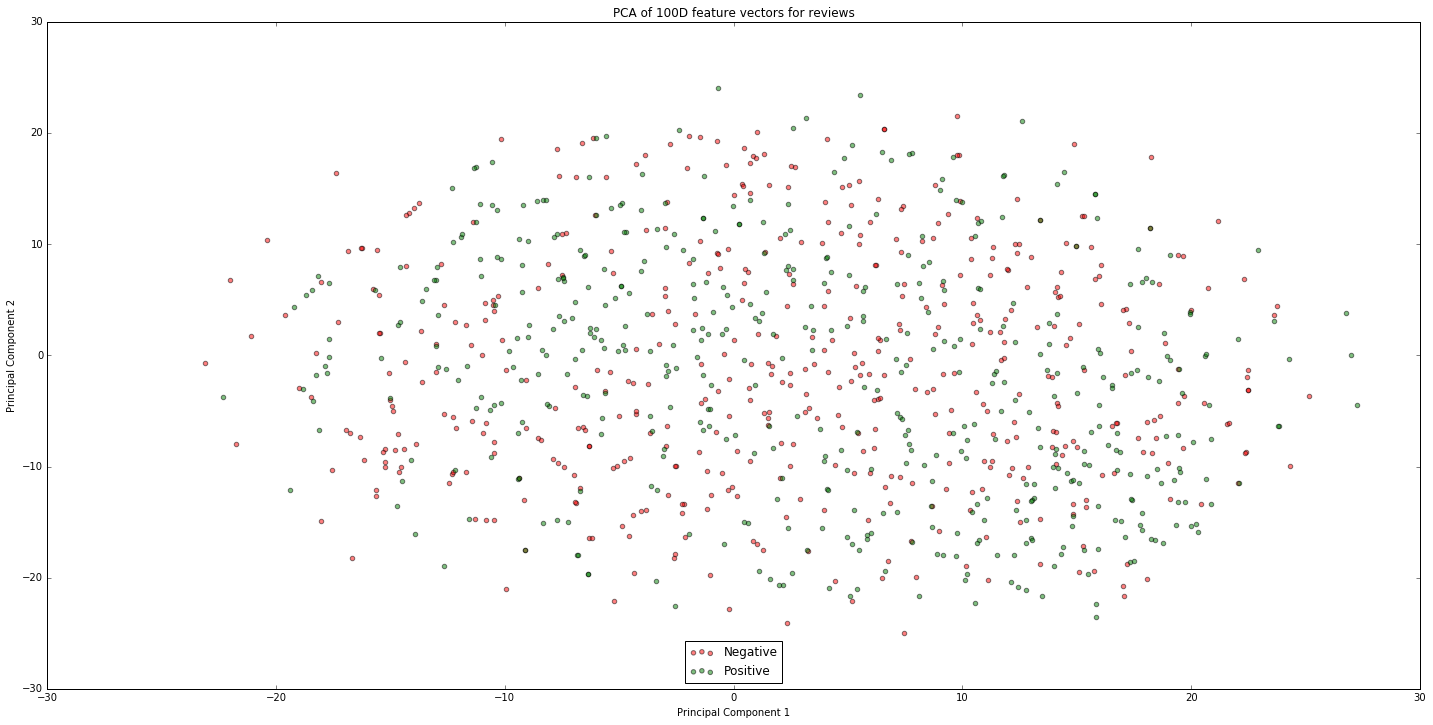

In [12]:
# Visualise the documents
%pylab inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Select 1000 examples to visualise
idx = np.random.choice(np.arange(len(train_labels)), 1000, replace=False)

X = train_data_features[idx].toarray()
y = np.array(train_labels)[idx]

#pca = PCA(n_components=50)
#pca_50_r = pca.fit(X).transform(X)

tsne = TSNE(n_components=2, verbose=1)
X_r = tsne.fit_transform(X)

plt.style.context('seaborn-whitegrid')
plt.figure(figsize=(20,10))
for c, i, target_name in zip("rg", [0, 1], ['Negative', 'Positive']):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, alpha=0.5, label=target_name)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower center')
plt.tight_layout()
plt.title('PCA of 100D feature vectors for reviews')

## B. Feature Importance

In [16]:
# Tree based estimators can be used to compute feature importances
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
# n_jobs = -1 can make this fly!
forest = ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

X, y = train_data_features, train_labels
forest.fit(X, y)

importances = forest.feature_importances_
# Include standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]
vocab = vectorizer.get_feature_names()

In [18]:
# Print the feature ranking
feat, feat_imp, feat_std = [], [], []

print("Feature ranking:")
for f in range(20):
    print("%d. feature \"%s\" (%f)" % (f + 1, vocab[int(indices[f])], importances[indices[f]]))
    feat.append(vocab[int(indices[f])])
    feat_imp.append(importances[indices[f]])
    feat_std.append(std[indices[f]])

Feature ranking:
1. feature "not" (0.011544)
2. feature "great" (0.008364)
3. feature "love" (0.005857)
4. feature "waste" (0.003796)
5. feature "and" (0.003290)
6. feature "easy to" (0.003021)
7. feature "disappointed" (0.003010)
8. feature "return" (0.002764)
9. feature "would not" (0.002692)
10. feature "easy" (0.002570)
11. feature "perfect" (0.002526)
12. feature "money" (0.002447)
13. feature "but" (0.002403)
14. feature "at all" (0.002236)
15. feature "do not" (0.002144)
16. feature "very disappointed" (0.002111)
17. feature "waste of" (0.002111)
18. feature "well" (0.002063)
19. feature "did not" (0.002042)
20. feature "highly" (0.002030)


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


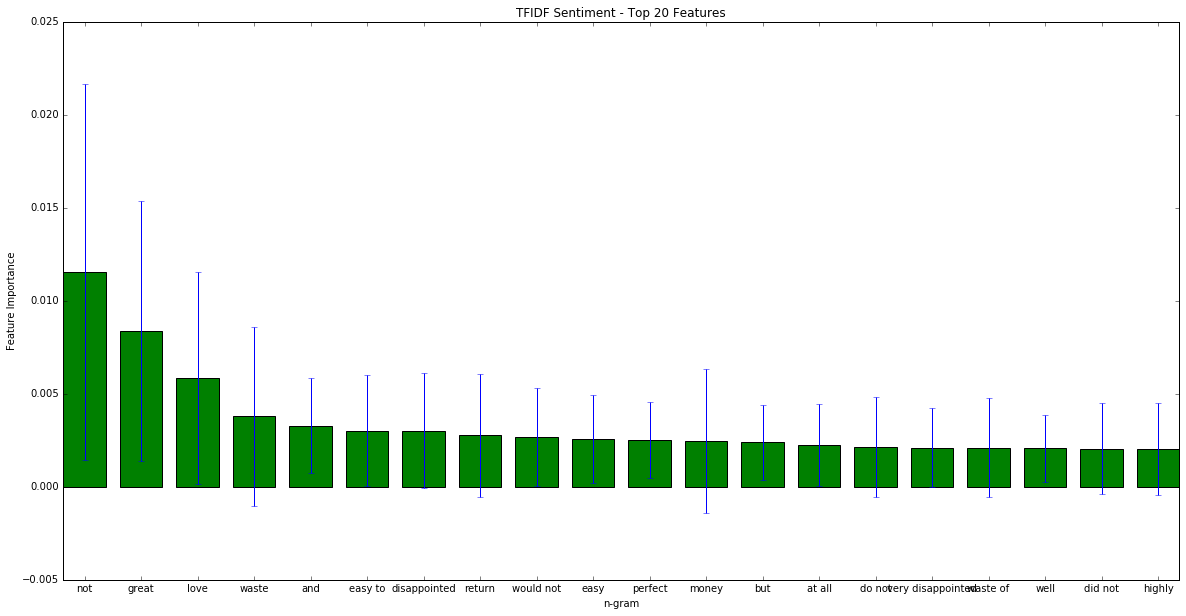

In [19]:
# Plot
ind = np.arange(len(feat))
width = .75

plt.figure(figsize=(20,10))
plt.xlabel('n-gram')
plt.ylabel('Feature Importance')
plt.title('TFIDF Sentiment - Top 20 Features')

plt.xticks(ind + width/2., (feat))
plt.bar(ind, feat_imp, width, color="g", yerr=feat_std)
plt.show()

In [20]:
del train_data_features
del train_labels
del importances
del vocab
del indices
#del forest

## C. Classification

In [22]:
# Testing Data
clean_test_reviews = []
test_labels = []
for f in ['test_good_reviews.txt',
          'test_bad_reviews.txt']:
    for review in file_to_list(f):
        clean_test_reviews.append(utils.to_unicode(review))
        if "good" in f:
            test_labels.append(1)
        elif "bad" in f:
            test_labels.append(0)
        else:
            raise Exception
                   
print("Sample review: %s" % clean_test_reviews[0])
print("Vectorising ... %d reviews" % len(clean_test_reviews))  

# Transform documents to document-term matrix
test_data_features = vectorizer.transform(clean_test_reviews)

del clean_test_reviews
print("done")

Sample review: easy to use a mobile . if you ' re taller than ft , be ready to tuck your legs behind you as you hang and pull .

Vectorising ... 1000627 reviews
done


In [34]:
# Run classifier
classifier_tfidf.score(test_data_features, test_labels) 

# 50k gives 0.915
# 500k gives 0.928
# 1mill gives 0.931

0.93074642199341018

In [23]:
# By the way, the forest we trained doesn't do so well:
forest.score(test_data_features, test_labels) 

0.89869451853687743

In [24]:
del forest

## D. Evaluate

In [35]:
tricky_sentences = [
    "Most movies are rubbish, however this one was good",
    "This is a product you would love to hate",
    "Rubbish from start to finish",
    "I was so happy when this ended",
    "Very good",
    "Horrible"
]

In [36]:
# Some tests ...
def tfidf_sample_sentiment(mystr):
    assert isinstance(mystr, str)
    test_data_feat = vectorizer.transform([mystr])
    pred = classifier_tfidf.predict(test_data_feat)
    return pred

for x in tricky_sentences:
    clean = clean_review(x)
    print(clean, tfidf_sample_sentiment(clean))    

most movies are rubbish , however this one was good
 [0]
this is a product you would love to hate
 [0]
rubbish from start to finish
 [0]
i was so happy when this ended
 [1]
very good
 [1]
horrible
 [0]


In [37]:
del vectorizer
del classifier_tfidf
del test_data_features
del test_labels